<a href="https://colab.research.google.com/github/tayontech/TFH-Analysis/blob/main/tp_secrepo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import requests
import gzip
from io import BytesIO
import ipaddress
import json

urls = [
    "http://www.secrepo.com/self.logs/access.log.2025-01-30.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-01-31.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-02-01.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-02-02.gz"
]

# Regular expression with named capture groups
regex_pattern = r'''(?P<SourceIp>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - (?P<RemoteUser>\S+) \[(?P<TimeLocal>.*?)\] "(?P<Request>.*?)" (?P<Status>\d+) (?P<BodyBytesSent>\d+) "(?P<HttpReferer>.*?)" "(?P<HttpUserAgent>.*?)"'''
compiled_regex = re.compile(regex_pattern)

# Function to extract groups from log line
def extract_groups(text):
    match = compiled_regex.match(text)
    if match:
        return match.groupdict()
    else:
        return {name: None for name in compiled_regex.groupindex}

# Main processing function
def process_logs(output_file=None, verbose=False):
    try:
        content = ""
        for url in urls:
            response = requests.get(url, stream=True)
            response.raise_for_status()

            # Try decompressing; fallback to plain text if gzip fails
            try:
                gzip_file = gzip.GzipFile(fileobj=BytesIO(response.content))
                one_content = gzip_file.read().decode('utf-8')
            except gzip.BadGzipFile:
                one_content = response.content.decode('utf-8')

            content += one_content

        # Parse log lines
        lines = content.splitlines()
        extracted_data = [extract_groups(line) for line in lines]

        # Create DataFrame for transformation
        df = pd.DataFrame(extracted_data)
        df.replace('-', None, inplace=True)
        df['TimeLocal'] = pd.to_datetime(df['TimeLocal'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
        df.drop('RemoteUser', axis=1, inplace=True)
        df['Status'] = pd.to_numeric(df['Status'], errors='coerce')
        df['BodyBytesSent'] = pd.to_numeric(df['BodyBytesSent'], errors='coerce')
        df['SourceIp'] = df['SourceIp'].apply(lambda ip: str(ipaddress.ip_address(ip)) if ip else None)

        # Convert DataFrame to JSON records
        json_records = df.to_dict(orient='records')

        if output_file:
            with open(output_file, 'w') as f:
                json.dump(json_records, f, indent=2, default=str)
        if verbose or not output_file:
            for record in json_records:
                print(json.dumps(record, indent=2, default=str))

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Usage:
# To print to console
process_logs(verbose=True)


{
  "SourceIp": "136.227.181.250",
  "TimeLocal": "2025-01-30 00:54:06-08:00",
  "Request": "GET /DatasetsDescription/Network/weird.html HTTP/1.1",
  "Status": 301,
  "BodyBytesSent": 495,
  "HttpReferer": null,
  "HttpUserAgent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
}
{
  "SourceIp": "134.199.68.150",
  "TimeLocal": "2025-01-30 00:54:07-08:00",
  "Request": "GET /DatasetsDescription/Network/tunnel.html HTTP/1.1",
  "Status": 301,
  "BodyBytesSent": 497,
  "HttpReferer": null,
  "HttpUserAgent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
}
{
  "SourceIp": "40.77.167.235",
  "TimeLocal": "2025-01-30 00:54:49-08:00",
  "Request": "GET /self.logs/error.log.2023-02-28.gz HTTP/1.1",
  "Status": 200,
  "BodyBytesSent": 1216,
  "HttpReferer": null,
  "HttpUserAgent": "Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2

# Convert Data to JSON


I modified the code to output data in JSON format, making it easier to work with using either Pandas or jq. Since I’m more familiar with JSON, I stuck with that approach and exported the results to a JSON file for further analysis. While I later realized that jq isn’t easily usable within Jupyter Notebooks without significant workarounds, I’ll still keep the JSON format because it preserves the entire event structure.

# Overview of Data

My initial goal was to get a high-level view of the data to identify potential pivot points or surface any obvious issues.

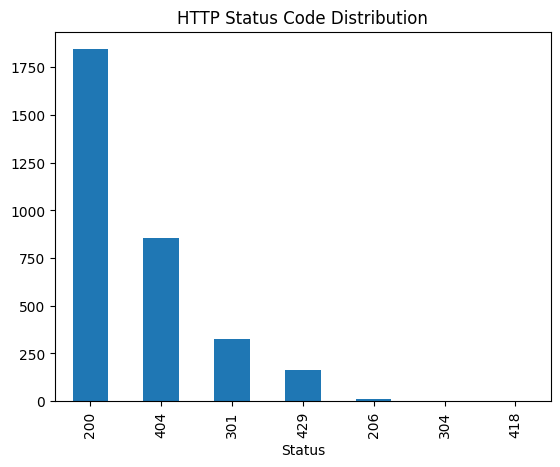

In [ ]:
import matplotlib.pyplot as plt

status_counts = df['Status'].value_counts()
status_counts.plot(kind='bar', title='HTTP Status Code Distribution')
plt.show()


In [ ]:
enum_attempts = df[df['Status'] == 404]

# Group by SourceIp and UserAgent, then join Requests into one cell
grouped_404 = enum_attempts.groupby(['SourceIp', 'HttpUserAgent']).agg({
    'Request': lambda x: ', '.join(sorted(set(x))),
    'TimeLocal': 'count'
}).rename(columns={'Request': 'Requests', 'TimeLocal': 'Total404s'}).reset_index()

grouped_404 = grouped_404.sort_values('Total404s', ascending=False)
display(grouped_404.head(10))


,SourceIp,HttpUserAgent,Requests,Total404s
188,152.32.170.13,Mozilla/5.0 (Linux; Android 11; vivo 1906; wv)...,"GET /$web/index.html HTTP/1.1, GET /035/index....",316
21,65.108.41.10,Mozilla/5.0 (compatible; SeekportBot; +https:/...,GET /Datasets%20Description/HTML_Bro_log_1/%20...,28
194,167.172.60.255,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,GET /.well-known/acme-challenge/iR7SzrsOUEP.ph...,27
195,167.172.165.51,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,"GET /.tmb/plugins.php HTTP/1.1, GET /.well-kno...",25
49,77.78.225.32,Go-http-client/1.1,"GET /.env HTTP/1.1, GET /.git/config HTTP/1.1,...",11
57,104.28.33.131,MobileSafari/8620.2.4.10.7 CFNetwork/3826.400....,GET /apple-touch-icon-120x120-precomposed.png ...,8
118,149.88.111.79,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,GET /.well-known/pki-validation/moon.php HTTP/...,8
138,149.88.111.79,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,"GET /.well-known/admin.php HTTP/1.1, GET /cont...",7
114,149.88.111.79,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...,"GET /.well-known/wp-conf.php HTTP/1.1, GET /ad...",7
120,149.88.111.79,Mozilla/5.0 (Windows NT 10.0; WOW64; x64) Appl...,GET /.well-known/pki-validation/wp-conf.php HT...,6


## 404 Error Deep Dive

I noticed there were quite a few `404` errors, so I performed a deep dive on the IP with the most failed requests to understand what was happening.

---

**Source IP:** `152.32.170.13`

**User Agent:**  `Mozilla/5.0 (Linux; Android 11; vivo 1906; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/87.0.4280.141 Mobile Safari/537.36 VivoBrowser/8.9.0.0 uni-app Html5Plus/1.0`



**Key Findings**  
- This source looked for admin consoles and script‑execution entry points:
  - `GET /admin`  
  - `GET /admin/webadmin.php?mod=do&act=login`  
  - `GET /install.inc/vipsignInstall.css`  

- It attempted to interact with multiple backend apis:
  - `POST /api/notice`
  - `POST /Ctrls/GetSysCoin`
  - `POST /km.asmx/getPlatParam`  

- It probed for misconfigured Azure blob sites:
  - `GET /$web/index.html`  

- It fuzzed initialization and API endpoints, these will warrant a closer review:
  - `GET /Public/initJs.php`  
  - `GET /Home/GetInitSource`  
  - `GET /api/api/exchangerateuserconfig!get.action`

  ---
  **Source IP:** `65.108.41.10`

  **User Agent:**  `Mozilla/5.0 (compatible; SeekportBot; +https://bot.seekport.com)`

  **Observations**  
- This appears to be a legitimate crawler, but some requests contain embedded external URLs in the path.  
- Although its 404 volume is low, these malformed paths could indicate log‑file artifact replay or probing for SSRF/open‑redirect bugs.

##Identifying Non 404 Activity
The threat actor did not successfully identify any valid endpoints, this activity appears to be purely enumeration. These IPs will be excluded from any further analysis.

In [ ]:
target_ips = [
    '152.32.170.13', '65.108.41.10', '167.172.60.255',
    '167.172.165.51', '77.78.225.32', '149.88.111.79', '104.28.33.131'
]

non_404_activity = df[(df['SourceIp'].isin(target_ips)) & (df['Status'] != 404)]

if not non_404_activity.empty:
    display(non_404_activity[['SourceIp', 'TimeLocal', 'Request', 'Status', 'BodyBytesSent', 'HttpReferer', 'HttpUserAgent']])
else:
    print("No non-404 activity found for the specified IPs.")


No non-404 activity found for the specified IPs.


## 206 Error Deep Dive (Potential Exfiltration)
This raises a flag for potential data exfiltration activity, possibly through partial downloads from the server.

In [ ]:
dl = df[df['Status'] == 206]
display(dl[[ 'TimeLocal', 'SourceIp', 'Request', 'BodyBytesSent']].sort_values(by='BodyBytesSent', ascending=False))


,TimeLocal,SourceIp,Request,BodyBytesSent
66,2025-01-30 04:50:05-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,110600
68,2025-01-30 04:50:07-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,110600
74,2025-01-30 04:50:24-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,107800
70,2025-01-30 04:50:08-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,107800
72,2025-01-30 04:50:10-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,105000
65,2025-01-30 04:50:05-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
69,2025-01-30 04:50:08-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
67,2025-01-30 04:50:06-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
71,2025-01-30 04:50:10-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
73,2025-01-30 04:50:24-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447


There seems to be a successful attempt at exfiltration file `conn.log.zip` from `85.117.96.24`